# Exploratory Data Analysis

This analysis will help me get familiar with dataset and find the opportunities to do feature engineering

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from EDA import EDA

In [2]:
pd.set_option('display.max_columns', 40)

Pandas cannot handel 6G data while simply reading it.
There are four solutions I can think of:
1. reading only a few columns and analyze at once. However, calculation such as correlation might be a problem in the future even I successfully read in the data.
2. specify each dtype since default dtype takes more memories. However it might have future problem asa point 1.
3. load data in as matrix
4. use spark

Of all the solutioins above, I will try second method first just to test if I can load in the data this way and I am just so familiar analyzing data using pandas, can't give it up so quick without giving it a shot.
However, I think it makes more sense to use spark for following reasons:
1. It can ba a lot faster when doing calculation.
2. The dataset I have only cover 7 days of behavoior data, In the real world setting, I think this type of data is the classic "big data" people are talking all the time. And spark is designed for handling this type of data! 
3. Because the reason in bullet point 2, even I am not dealing with sreaming data, It is better to showcase I have this skillset to the employers.

# Load Data

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession \
    .builder \
    .appName("EDA") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1600465900533'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'EDA'),
 ('spark.driver.port', '45333'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '192.168.2.162')]

In [5]:
data_dir = "../MLE_Project_Data"
data_file_name = "train_data.csv"
data_path = os.path.join(data_dir,data_file_name)

raw_df = spark.read.load(data_path,format="csv",delimiter="|",header=True)

# Examine Dataset

In [6]:
raw_df_shape = (raw_df.count(),len(raw_df.columns))
print(f"The shape: {raw_df_shape}")

The shape: (41907133, 36)


In [7]:
# head
raw_df_head = [row.asDict() for row in raw_df.head(5)]
pd.DataFrame(raw_df_head)

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,app_first_class,app_second_class,age,city,city_rank,device_name,device_size,career,gender,net_type,residence,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d
0,0,1638254,2112,6869,7,207,17,5,11,13,37,4,21,5,437,5,37,162,4,2,2,28,4,2,2,20,4,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,17,1
1,0,1161786,3104,3247,7,183,29,5,17,86,37,4,21,4,370,5,59,141,9,4,2,26,4,3,2,20,4,4,18,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,17,1
2,0,1814783,5890,4183,7,178,17,5,11,70,39,4,17,5,306,3,81,162,4,2,2,21,2,3,2,20,4,5,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,11,36,1
3,0,1468996,1993,5405,7,207,17,5,21,13,37,4,21,5,275,5,88,180,4,2,2,23,4,2,2,20,7,3,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,11,17,1
4,0,2164010,5439,4677,2,138,24,5,12,33,15,4,15,5,412,3,88,180,4,2,2,20,16,3,2,20,7,3,-1,-1,-1,2,2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^...,11,20,1


In [8]:
# tail
raw_df_tail = [row.asDict() for row in raw_df.tail(5)]
pd.DataFrame(raw_df_tail)

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,app_first_class,app_second_class,age,city,city_rank,device_name,device_size,career,gender,net_type,residence,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d
0,0,2154906,5275,5473,7,156,56,5,13,58,37,4,21,6,255,3,87,117,9,2,2,18,14,3,2,28,5,4,18,-1,-1,2,1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^1...,13,17,7
1,0,1466996,5952,4158,7,207,17,5,17,13,37,4,21,5,335,3,75,141,4,4,2,38,4,3,2,20,8,5,18,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,17,7
2,0,1930657,2178,1860,2,142,60,5,12,80,41,2,26,5,140,4,29,141,10,2,3,30,-1,-1,1,20,9,3,-1,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,24,7
3,0,1550398,1976,6739,7,154,56,5,11,31,40,4,25,5,275,5,38,162,3,2,2,23,13,3,2,20,4,4,20,1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,11,17,7
4,0,1400807,3869,6751,7,130,30,5,13,28,39,4,17,4,406,5,65,141,4,2,2,21,6,2,2,14,10,2,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,36,7


In [9]:
# dtypes
raw_df.schema.fields

[StructField(label,StringType,true),
 StructField(uid,StringType,true),
 StructField(task_id,StringType,true),
 StructField(adv_id,StringType,true),
 StructField(creat_type_cd,StringType,true),
 StructField(adv_prim_id,StringType,true),
 StructField(dev_id,StringType,true),
 StructField(inter_type_cd,StringType,true),
 StructField(slot_id,StringType,true),
 StructField(spread_app_id,StringType,true),
 StructField(tags,StringType,true),
 StructField(app_first_class,StringType,true),
 StructField(app_second_class,StringType,true),
 StructField(age,StringType,true),
 StructField(city,StringType,true),
 StructField(city_rank,StringType,true),
 StructField(device_name,StringType,true),
 StructField(device_size,StringType,true),
 StructField(career,StringType,true),
 StructField(gender,StringType,true),
 StructField(net_type,StringType,true),
 StructField(residence,StringType,true),
 StructField(his_app_size,StringType,true),
 StructField(his_on_shelf_time,StringType,true),
 StructField(app_

In [10]:
raw_df.columns

['label',
 'uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

In [11]:
# describe
describe = raw_df.describe()
describe.toPandas().set_index("summary").T

summary,count,mean,stddev,min,max
label,41907133,0.034492648304048856,0.18249083898022259,0,1
uid,41907133,1618366.5450654665,357389.65521592135,1000001,2237673
task_id,41907133,3436.3739258660335,1429.9486235761321,1001,5992
adv_id,41907133,3963.51341013951,1720.5691813375768,1001,7020
creat_type_cd,41907133,6.490081748135813,1.231181612514361,2,9
adv_prim_id,41907133,159.31912006483478,30.899225966287723,101,214
dev_id,41907133,41.59357343772479,17.41486835377897,11,72
inter_type_cd,41907133,4.646959504483402,0.7103276382288628,2,5
slot_id,41907133,15.254736109005595,3.167097985067854,11,22
spread_app_id,41907133,51.9989373646725,25.10112386162042,11,89


Most of the columns are acutallly categorical variables, doesn't make sense to lokking at those statistics.
However, this summary is a way to confirm whether those categorical columns are really categorical

In [12]:
numeric_columns = ["age","device_size",'his_app_size','app_score','device_price']

In [13]:
# describe
describe = raw_df.select(numeric_columns) \
    .describe()
describe.toPandas().set_index("summary").T

summary,count,mean,stddev,min,max
age,41907133,5.055212772489113,1.4153192617965202,-1,7
device_size,41907133,158.2104430527376,45.07228338655767,101,349
his_app_size,41907133,6.5524609378551375,5.898097528503572,-1,9
app_score,41907133,1.7847627037621494,0.41098686910490795,1,2
device_price,41907133,3.476986387973618,1.1587958240779863,-1,7


Seems like even these are numerical variables but they are already benn grouped by a different bucket levels.
Because there is no further explanation, I need to make a few assumptions:
1. value = -1 equal missing value
2. value of app_score is actual score
3. device price 1-7 means cheap to expensive
4. age 1-7 means young to old

This discovery means when processing data for models, I need to create a lot dummy variables.

# Explore Data

## label distribution

In [ ]:
label_count = raw_df.select("label").groupby("label").count().toPandas()

In [ ]:
label_count["pct"] = np.round(label_count["count"].values/raw_df_shape[0],decimals=3)
label_count

,label,count,pct
0,0,40461645,0.966
1,1,1445488,0.034


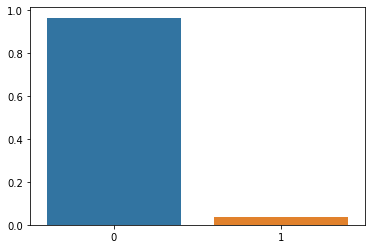

In [ ]:
plot = sns.barplot(label_count["label"].values,label_count["count"].values/raw_df_shape[0])

The label distribution is imbalance. But it is expected. This means CTR in this dataset is around 3.5% which is better than the average CTR number I googled.
<img src="images/avg_ctr.png">

## ID columns

In [ ]:
raw_df.columns

['label',
 'uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

In [ ]:
id_columns = ['uid','task_id','adv_id','creat_type_cd','adv_prim_id','dev_id','inter_type_cd','slot_id','spread_app_id']

In [ ]:
for col in id_columns:
    raw_df.select(F.countDistinct(col)).distinct().show()

+-------------------+
|count(DISTINCT uid)|
+-------------------+
|            1081436|
+-------------------+



After looking at id columns closely, I discoverd 
1. some features are really ID, some  features are not
2. some id values are actully a feature to another higher level features.

With these two findings I constructed following feature map:

1. users:
    - uid
    - age 
    - city
        - city_rank
        - residence
    - career
    - gender
    - up_life_duration
    - up_membership_grade
    - membership_life_duration
    - consume_purchase
    - communication_onlinerate
    - communication_avgonline_30d
2. ads
    - task_id
    - adv_id
    - creat_type_cd
    - adv_prim_id
    - dev_id
    - inter_typ_cd
    - slot_id
    - indu_name
3. apps
    - spread_app_id
    - tags
    - app_first_class
    - app_second_class
    - his_app_size
    - his_on_shelf_time
    - app_score
4. device
    - device_name
    - device_size
    - emui_dev
    - list_time
    - device_price
6. behavior/event
    - net_type
    - pt_d
   
I will start explore features following this feature map

## Users

users:
- uid
- age 
- city
    - city_rank
    - residence
- career
- gender
- up_life_duration
- up_membership_grade
- membership_life_duration
- consume_purchase
- communication_onlinerate
- communication_avgonline_30d

### uid

In [ ]:
# Instantiating EDA object
eda = EDA(target_ctr=0.035)
# cast label into int for calculation
raw_df = raw_df.withColumn("label_int",raw_df["label"].cast("integer"))

In [ ]:
high_ctr_uids, low_ctr_uids = eda.id_analysis(raw_df,"uid")

In [ ]:
user_features = ["age",                 
                 #city,
                 "city_rank",
                 "residence",
                 "career",
                 "gender",
                 "up_life_duration",
                 "up_membership_grade",
                 "membership_life_duration",
                 "consume_purchase",
                 #"communication_onlinerate",
                 "communication_avgonline_30d"
                ]

In [ ]:
for feature in user_features:
    print(f"ANALYZE {feature}")
    eda.cat_analysis(raw_df,feature,"uid")
    eda.high_low_ctr_group_dist(raw_df,feature,"uid",high_ctr_uids,low_ctr_uids)
    print("")
    print("="*20)
    print("")

## communication_onlinerate

In [ ]:
raw_df.select(F.split(raw_df.communication_onlinerate,"^")).show()

So weird that it didn't split on "^", I have to try another way

In [ ]:
# parse out only start and end time
raw_df = raw_df.withColumn("start_communication_onlinerate",raw_df.communication_onlinerate.substr(1,2))
raw_df = raw_df.withColumn("start_communication_onlinerate",F.regexp_extract(raw_df.start_communication_onlinerate,r'(\d+)',1))
raw_df = raw_df.withColumn("last_communication_onlinerate",raw_df.communication_onlinerate.substr(-2,2))
raw_df = raw_df.withColumn("last_communication_onlinerate",F.regexp_extract(raw_df.last_communication_onlinerate,r'(\d+)',1))

raw_df.select("start_communication_onlinerate","last_communication_onlinerate").show()

In [ ]:
# make ending at 0 convert to 24
raw_df = raw_df.withColumn("last_communication_onlinerate"\
                           ,F.when(raw_df.last_communication_onlinerate == 0, 24)\
                           .otherwise(raw_df.last_communication_onlinerate))

In [ ]:
# calculate the online duration in that day
raw_df = raw_df.withColumn("duration_communication_onlinerate"\
                  ,raw_df.last_communication_onlinerate-raw_df.start_communication_onlinerate)

In [ ]:
for feature in ["start_communication_onlinerate","last_communication_onlinerate","duration_communication_onlinerate"]:
    print(f"ANALYZE {feature}")
    eda.cat_analysis(raw_df,feature,"uid")
    eda.high_low_ctr_group_dist(raw_df,feature,"uid",high_ctr_uids,low_ctr_uids)
    print("")
    print("="*20)
    print("")

# Ads

Can't tell the difference between task_id and adv_id, however it seems like most ad features are belong to task_id, gonna use task_id as prime identifier of ads.

In [ ]:
ads_features = ["creat_type_cd",
                "adv_prim_id",
                "dev_id",
                "inter_typ_cd",
                "slot_id",
                "indu_name"]

In [ ]:
high_ctr_task_ids, low_ctr_task_ids = eda.id_analysis(raw_df,"task_id")

In [ ]:
for feature in ads_features:
    print(f"ANALYZE {feature}")
    eda.cat_analysis(raw_df,feature,"task_id")
    eda.high_low_ctr_group_dist(raw_df,feature,"task_id",high_ctr_task_ids, low_ctr_task_ids)
    print("")
    print("="*20)
    print("")

# Apps

In [ ]:
app_features = ["tags",
                "app_first_class",
                "app_second_class",
                "his_app_size",
                "his_on_shelf_time",
                "app_score"]

In [ ]:
high_ctr_app_ids, low_ctr_app_ids = eda.id_analysis(raw_df,"spread_app_id")

In [ ]:
for feature in ads_features:
    print(f"ANALYZE {feature}")
    eda.cat_analysis(raw_df,feature,"spread_app_id")
    eda.high_low_ctr_group_dist(raw_df,feature,"spread_app_id",high_ctr_app_ids, low_ctr_app_ids)
    print("")
    print("="*20)
    print("")

# Device

In [ ]:
device_features = ["device_size",
                   "emui_dev",
                   "list_time",
                   "device_price"]

In [ ]:
high_ctr_device_ids, low_ctr_device_ids = eda.id_analysis(raw_df,"device_name")

In [ ]:
for feature in ads_features:
    print(f"ANALYZE {feature}")
    eda.cat_analysis(raw_df,feature,"device_name")
    eda.high_low_ctr_group_dist(raw_df,feature,"device_name",high_ctr_device_ids, low_ctr_device_ids)
    print("")
    print("="*20)
    print("")

# Environment

In [ ]:
eda.cat_analysis(raw_df,"net_type","net_type")

In [ ]:
eda.cat_analysis(raw_df,"pt_d","pt_d")